In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from mpl_toolkits.mplot3d import Axes3D

# For reproducibility:
np.random.seed(42)

In [53]:
r = 0.05           # Risk-free rate
sigma_true = 0.02   # "True" volatility used to generate synthetic data
S0 = 100.0         # Spot price
T = 1.0            # Time to maturity (in years)
N = 20             # Number of strikes we want to simulate
noise_level = 0.01  # Scale of random noise added to the option price
K_min, K_max = 80, 120   # range for underlying price S

# Generate a range of strikes
K_values = np.linspace(80, 120, N)  # Strikes from 80 to 120

In [54]:
def plotter(title, K_vals,T_vals,implied_vols):
    # Note: We'll plot with S on one axis, t on another, and call value on the z-axis.
    K_grid, T_grid = np.meshgrid(K_vals, T_vals)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # IMPORTANT: call_values is indexed as [S_index, t_index],
    # but meshgrid returns [t, S] in (t_grid, S_grid).
    # So we either transpose call_values or swap the axes before plotting.
    # We'll transpose call_values so Z matches X=S_grid, Y=t_grid.
    surf = ax.plot_surface(K_grid, T_grid, implied_vols, cmap='viridis')

    ax.set_title(title)
    ax.set_xlabel("Strike K")
    ax.set_ylabel("Maturity t")
    ax.set_zlabel("Implied Volatility")
    
    ax.view_init(elev=20, azim=-34)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

In [55]:
def black_scholes_call(S, K, r, sigma, T):
    """
    Black–Scholes formula for a European call option.
    S: current underlying price
    K: strike price
    r: risk-free interest rate
    sigma: volatility
    T: time to maturity
    """
    if T <= 0:
        return max(S - K, 0)
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call = (S * norm.cdf(d1) 
            - K * np.exp(-r * T) * norm.cdf(d2))
    return call

## Back out IV

To get implied volatility from a given market (or in this case, noisy synthetic) price, we solve the equation:

$$
BSCall(S_0,K,r,\sigma,T)−ObservedPrice = 0 
$$

In [57]:
k_vals = np.arange(K_min, K_max)
exact_prices = [black_scholes_call(S0, K, r, sigma_true, T) for K in k_vals]
noisy_prices = exact_prices+ noise_level*np.exp(np.random.randn(len(exact_prices)))
noisy_prices[0:10]

array([23.90981499, 22.965796  , 22.0011804 , 21.05009024, 20.19197987,
       19.1798066 , 18.21584496, 17.24821001, 16.29969262, 15.35056446])

In [6]:
# Back out the impled vol surface of a call option given price and maturity
def implied_vol_call(price, S, K, r, T, vol_lower=1e-6, vol_upper=3.0):
    """
    Computes implied volatility for a European call using Brent's method.
    price: observed (or market) call price
    S: current underlying price
    K: strike
    r: risk-free rate
    T: time to maturity
    """
    # Define a function whose root we want to find
    def f(sigma):
        return black_scholes_call(S, K, r, sigma, T) - price
    
    # We need to handle potential issues:
    # If the 'price' is outside the theoretical min or max,
    # a solution might not exist. We keep it simple here.
    
    # Check for immediate edge cases:
    #   - Price > S => implied vol does not exist (for a call)
    if price > S:
        return np.nan
    
    try:
        # We'll assume there's a root in [vol_lower, vol_upper]
        vol = brentq(f, vol_lower, vol_upper)
        return vol
    except:
        # If no solution, return nan
        return np.nan


In [7]:
iv_from_exact_prices = [implied_vol_call(p, S0, K, r, T) for p,K in zip(exact_prices, k_vals)]
iv_from_noisy_prices = [implied_vol_call(p, S0, K, r, T) for p,K in zip(noisy_prices, k_vals)]

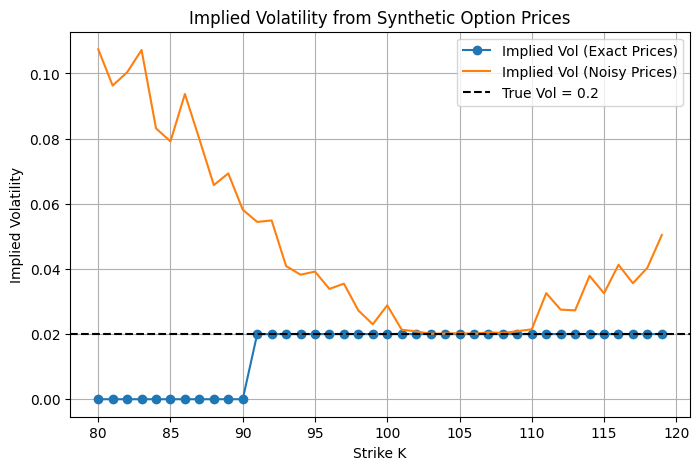

In [8]:
plt.figure(figsize=(8, 5))

plt.plot(k_vals, iv_from_exact_prices, "o-", label="Implied Vol (Exact Prices)")
plt.plot(k_vals, iv_from_noisy_prices, "-", label="Implied Vol (Noisy Prices)")

plt.axhline(sigma_true, color="black", linestyle="--", label="True Vol = 0.2")
plt.xlabel("Strike K")
plt.ylabel("Implied Volatility")
plt.title("Implied Volatility from Synthetic Option Prices")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
%matplotlib widget

In [73]:
# Suppose we have a grid of strikes:
K_vals = np.linspace(K_min, K_max, 100)  # 15 strikes from 80 to 120

# Multiple maturities
T_vals = np.linspace(0, 1.0, 10) # for example, 4 maturities

# Let's assume a "true" vol that might vary a bit with maturity:
# e.g., sigma_true(T) = 0.15 + 0.02 * sqrt(T)
def sigma_true_func(T):
    return (K/S0) * 0.15 + sigma_true * np.sqrt(T) # sigma_true

# We'll store the synthetic prices here
synthetic_prices = np.zeros((len(T_vals), len(K_vals)))

# 3.2 Generate synthetic prices
for i, T in enumerate(T_vals):
    sigma_T = sigma_true_func(T)
    exact_prices = [black_scholes_call(S0, K, r, sigma_T, T) for K in K_vals]
    noisy_prices = exact_prices + noise_level*np.random.randn(len(exact_prices))
    synthetic_prices[i, :] = noisy_prices
    


In [74]:
implied_vols = np.zeros_like(synthetic_prices)

for i, T in enumerate(T_vals):
    for j, K in enumerate(K_vals):
        price_obs = synthetic_prices[i, j]
        implied_vols[i, j] = implied_vol_call(price_obs, S0, K, r, T)
        # display(price_obs, T, K, implied_vol_call(price_obs, S0, K, r, T))

# plotter("Implied Volatility Surface", K_vals, T_vals, implied_vols)

In [75]:
true_vol_surface = np.zeros_like(implied_vols)

for i, T in enumerate(T_vals):
    # if we assume no strike-dependence
    true_vol_surface[i, :] = sigma_true_func(T)


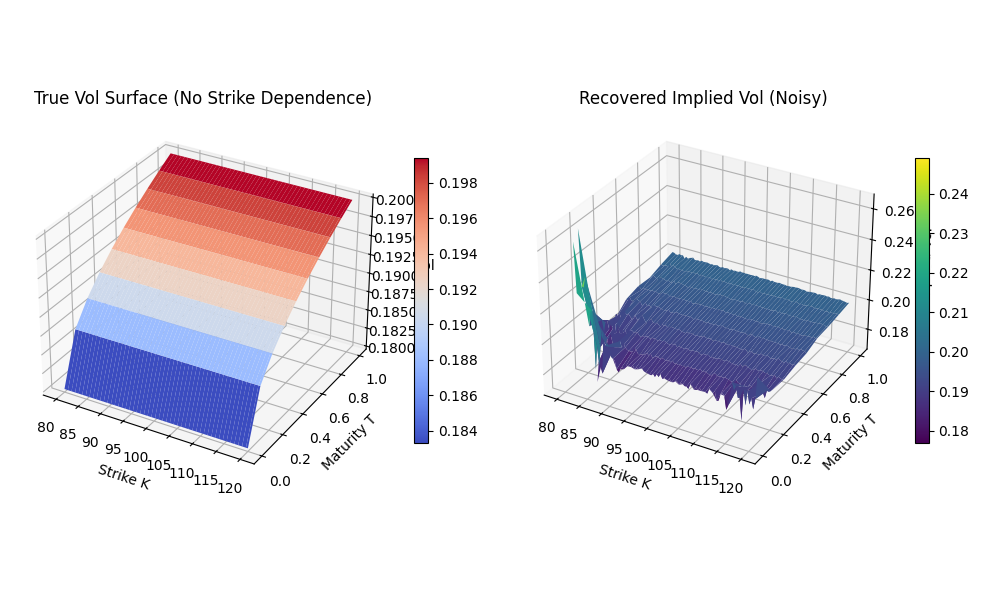

In [76]:
K_grid, T_grid = np.meshgrid(K_vals, T_vals)
fig = plt.figure(figsize=(10, 6))

ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(K_grid, T_grid, true_vol_surface, cmap='coolwarm')
ax1.set_title("True Vol Surface (No Strike Dependence)")
ax1.set_xlabel("Strike K")
ax1.set_ylabel("Maturity T")
ax1.set_zlabel("Vol")
fig.colorbar(surf1, ax=ax1, shrink=0.5)

ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(K_grid, T_grid, implied_vols, cmap='viridis')
ax2.set_title("Recovered Implied Vol (Noisy)")
ax2.set_xlabel("Strike K")
ax2.set_ylabel("Maturity T")
ax2.set_zlabel("Implied Vol")
fig.colorbar(surf2, ax=ax2, shrink=0.5)

plt.tight_layout()
plt.show()
